![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from datetime import datetime, timedelta
import re
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from textblob import TextBlob
from itertools import combinations
from scipy.stats import ttest_ind

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [4]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [5]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [7]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [8]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [9]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [10]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [11]:
df.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
43437,id_1344,Copenhagen,"['French', 'European', 'Danish']",1346.0,$$$$,4.0,"[['What you need', 'Nice breakfast in a good h...",/Restaurant_Review-g189541-d4129226-Reviews-Re...,d4129226,1,4.5
32549,id_550,Berlin,"['German', 'Bar', 'European', 'Pub', 'Vegetari...",551.0,$$ - $$$,151.0,"[['Fantastic blues in packed pub', 'Good food ...",/Restaurant_Review-g187323-d1438914-Reviews-Yo...,d1438914,1,4.0
8464,id_8464,Rome,"['Italian', 'Cafe']",3753.0,$$ - $$$,209.0,[['A Wonderful Place to Buy Quality Cooking S....,/Restaurant_Review-g187791-d2446097-Reviews-Ca...,d2446097,0,0.0
20326,id_4980,Milan,['Italian'],4983.0,NaN,33.0,"[[], []]",/Restaurant_Review-g187849-d6635103-Reviews-Ci...,d6635103,1,4.0
4166,id_4166,Krakow,"['Polish', 'European', 'Eastern European', 'Ce...",106.0,$$ - $$$,4608.0,"[['Traditional fayre - huge portions, good at....",/Restaurant_Review-g274772-d1009022-Reviews-Po...,d1009022,0,0.0


In [12]:
df.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# функции

In [13]:
# функция расчета выбросов
def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return lower_bound, upper_bound

In [14]:
# функция расчета стаистических закономерностей
def get_stat_dif(column):
    cols = df_stat.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df_stat.loc[df_stat.loc[:, column] == comb[0], 'rating'], 
                        df_stat.loc[df_stat.loc[:, column] == comb[1], 'rating']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [15]:
# функция округления результатов предсказания
def round_pred(y_pred):
    return [(round(y / 0.5) * 0.5) for y in y_pred]

In [16]:
# функция minmax нормализации столбца датасета
def MMS(ser):
    scaler = MinMaxScaler()
    x = np.array(ser).reshape(len(ser), 1)
    a = scaler.fit_transform(x)
    a_s = pd.Series(a.flatten())
    return a_s

In [17]:
# функция std нормализации столбца датасета
def stdS(ser):
    scaler = StandardScaler()
    x = np.array(ser).reshape(len(ser), 1)
    a = scaler.fit_transform(x)
    a_s = pd.Series(a.flatten())
    return a_s

In [18]:
print('названия колонок датасета\n', df.columns)

названия колонок датасета
 Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Price Range',
       'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating'],
      dtype='object')


переименуем колонки в удобные для работы названия

In [19]:
df.columns = ['id', 'city', 'cuisine', 'ranking',
       'price', 'number', 'reviews', 'URL_TA', 'ID_TA',
       'sample','rating']

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
id         50000 non-null object
city       50000 non-null object
cuisine    38410 non-null object
ranking    50000 non-null float64
price      32639 non-null object
number     46800 non-null float64
reviews    49998 non-null object
URL_TA     50000 non-null object
ID_TA      50000 non-null object
sample     50000 non-null int64
rating     50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


четыре колонки имеют пропуски, причем колонки cuisine и price содержат слишком много пропусков

/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


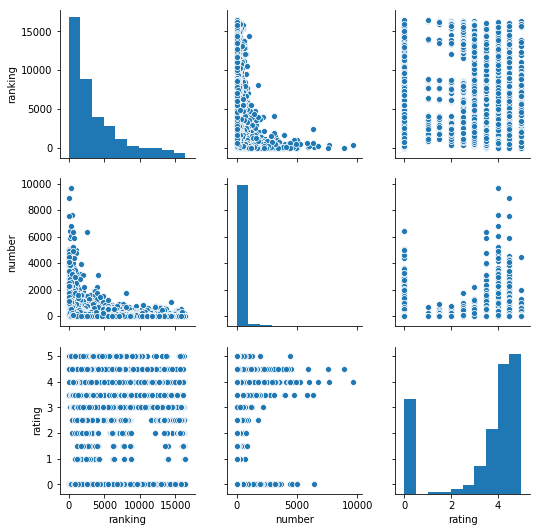

In [21]:
sns.pairplot(df.drop(['sample'], axis = 1));

числовые признаки распределены в основном экспоненциально, сосредоточены около предельных значений, имеют существенный разброс, некластеризированы

# *колонка* **cuisine**

In [22]:
print(df.cuisine)
print(df.cuisine[1])

0                                           ['Bar', 'Pub']
1        ['European', 'Scandinavian', 'Gluten Free Opti...
2                                  ['Vegetarian Friendly']
3        ['Italian', 'Mediterranean', 'European', 'Vege...
4        ['Italian', 'Mediterranean', 'European', 'Seaf...
                               ...                        
49995    ['Italian', 'Vegetarian Friendly', 'Vegan Opti...
49996    ['French', 'American', 'Bar', 'European', 'Veg...
49997                                ['Japanese', 'Sushi']
49998    ['Polish', 'European', 'Eastern European', 'Ce...
49999                                          ['Spanish']
Name: cuisine, Length: 50000, dtype: object
['European', 'Scandinavian', 'Gluten Free Options', 'Vegetarian Friendly', 'Vegan Options']


данные в колонке представляют из себя строку списков строк, требуется преобразование

In [23]:
# считаем количесвто пустых строк
print('количество пустых строк', df.cuisine.isna().sum())
# количесвто пустых строк в процентах
print('количесвто пустых строк в процентах', df.cuisine.isna().sum()/len(df)*100)


количество пустых строк 11590
количесвто пустых строк в процентах 23.18


мы видим очень много пустых строк, но в ресторане не может не быть кухни, как минимум одна все равно есть

In [24]:
# преобразуем строку списка в список и пустые строки назовем стандартная кухня
df3 = df.cuisine.copy()
df3 = df3.fillna('[standart]')
df3 = df3.apply(lambda x: str(x)[1:-1])
df3 = df3.apply(lambda x: x.replace("'", ''))
df3 = df3.str.split(', ')

In [25]:
# посмотрим на результат
df3[1]

['European',
 'Scandinavian',
 'Gluten Free Options',
 'Vegetarian Friendly',
 'Vegan Options']

In [26]:
# посчитаем количество кухонь
cuisine_all = df3.explode()
print(cuisine_all.value_counts())
print(cuisine_all.value_counts(normalize = True))
print(cuisine_all.nunique())

Vegetarian Friendly    14021
European               12561
standart               11590
Mediterranean           7820
Italian                 7433
                       ...  
Fujian                     2
Salvadoran                 1
Burmese                    1
Xinjiang                   1
Latvian                    1
Name: cuisine, Length: 126, dtype: int64
Vegetarian Friendly    0.106814
European               0.095691
standart               0.088294
Mediterranean          0.059574
Italian                0.056625
                         ...   
Fujian                 0.000015
Salvadoran             0.000008
Burmese                0.000008
Xinjiang               0.000008
Latvian                0.000008
Name: cuisine, Length: 126, dtype: float64
126


In [27]:
# проверим колонку на наличие статистически значимых различий
df_stat = pd.DataFrame()
df_stat['cuisine'] = df3
df_stat['rating'] = df['rating']
df_stat['sample'] = df['sample']
df_stat = df_stat.explode('cuisine')
df_stat = df_stat[df_stat['sample'] == 1]
df_stat = df_stat[df_stat['cuisine'] != '']
get_stat_dif('cuisine')

Найдены статистически значимые различия для колонки cuisine


колонка имеет статистически значимые различия с целевой переменной, но типов кухонь очень много, всего 126, преобразовать в dummy-переменные нецелесообразно

In [28]:
# посчитаем количество кухонь для каждого ресторана
df3_c = df3.apply(lambda x: len(x))
print('уникальные значения\n', df3_c.unique())
print('количество значений\n', df3_c.value_counts())
print('количество значений в процентах\n', df3_c.value_counts(normalize = True))
df['cuisine_c'] = df3_c

уникальные значения
 [ 2  5  1  6  3  4  7  8  9 10 15 11 13 21]
количество значений
 1     20744
2      7794
3      6638
4      5948
5      4482
6      2611
7      1294
8       363
9        93
10       26
11        4
21        1
15        1
13        1
Name: cuisine, dtype: int64
количество значений в процентах
 1     0.41488
2     0.15588
3     0.13276
4     0.11896
5     0.08964
6     0.05222
7     0.02588
8     0.00726
9     0.00186
10    0.00052
11    0.00008
21    0.00002
15    0.00002
13    0.00002
Name: cuisine, dtype: float64


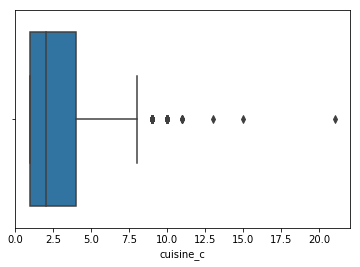

In [29]:
sns.boxplot(df['cuisine_c']);

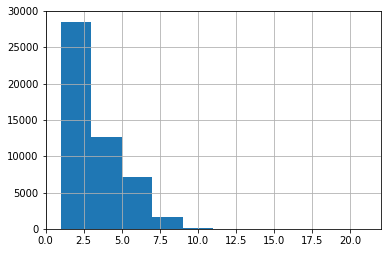

In [30]:
df.cuisine_c.hist();

In [31]:
print('выбросы', outliers_iqr(df.cuisine_c))

выбросы (-3.5, 8.5)


In [32]:
df[df.cuisine_c > 8.5]

,id,city,cuisine,ranking,price,number,reviews,URL_TA,ID_TA,sample,rating,cuisine_c
679,id_679,Madrid,"['Mexican', 'Latin', 'Contemporary', 'Fusion',...",168.0,$$ - $$$,144.0,[['Great Mexican cuisine is a lively neighbor....,/Restaurant_Review-g187514-d10494492-Reviews-M...,d10494492,0,0.0,9
832,id_832,Budapest,"['Italian', 'French', 'German', 'European', 'H...",422.0,$$ - $$$,41.0,"[['Nice place, nice staff', 'Perfect'], ['11/1...",/Restaurant_Review-g274887-d11806031-Reviews-M...,d11806031,0,0.0,10
1358,id_1358,Budapest,"['International', 'Grill', 'Barbecue', 'Europe...",319.0,$$ - $$$,241.0,"[['Good value for your money', 'Nice evening d...",/Restaurant_Review-g274887-d1023224-Reviews-Tr...,d1023224,0,0.0,9
2292,id_2292,Vienna,"['German', 'Austrian', 'European', 'Asian', 'C...",1379.0,$$ - $$$,42.0,"[['Traditional Austrian dishes', 'Delicious Au...",/Restaurant_Review-g190454-d1907599-Reviews-Gi...,d1907599,0,0.0,10
3184,id_3184,Rome,"['Italian', 'Pizza', 'Seafood', 'Mediterranean...",774.0,$$ - $$$,893.0,"[['Waterfront experience', 'Excellent location...",/Restaurant_Review-g187791-d1641052-Reviews-Cu...,d1641052,0,0.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...
48241,id_17,Edinburgh,"['Mediterranean', 'Barbecue', 'Turkish', 'Euro...",18.0,$$ - $$$,440.0,"[['Dinner', 'Still the best'], ['01/10/2018', ...",/Restaurant_Review-g186525-d8699437-Reviews-Ad...,d8699437,1,4.5,9
49276,id_67,Warsaw,"['Lebanese', 'Mediterranean', 'Middle Eastern'...",68.0,$$ - $$$,180.0,"[['Good place in Warsaw', 'Exceeded the expect...",/Restaurant_Review-g274856-d3854108-Reviews-Le...,d3854108,1,4.5,9
49413,id_93,Amsterdam,"['Asian', 'Italian', 'French', 'American', 'In...",94.0,$$ - $$$,1480.0,"[['Amazing place, great food & vibe - you MUS....",/Restaurant_Review-g188590-d7231902-Reviews-Fo...,d7231902,1,4.5,21
49614,id_106,Edinburgh,"['American', 'Bar', 'British', 'Pub', 'Scottis...",107.0,$$ - $$$,1072.0,"[['Great burgers!', 'Great for meat lovers, bu...",/Restaurant_Review-g186525-d1811602-Reviews-Th...,d1811602,1,4.5,9


в колонке есть выбросы, которые есть и в тестовой выборке, но их немного, попробуем избавится от них, не меняя их явно

In [33]:
# прологарифмируем значения в колонке
df.cuisine_c = df.cuisine_c.apply(lambda x: np.log(x))
print('максимальное значение', df.cuisine_c.max())
print('выбросы', outliers_iqr(df.cuisine_c))
print('значения и их количество', df.cuisine_c.value_counts())

максимальное значение 3.044522437723423
выбросы (-2.0794415416798357, 3.465735902799726)
значения и их количество 0.000000    20744
0.693147     7794
1.098612     6638
1.386294     5948
1.609438     4482
1.791759     2611
1.945910     1294
2.079442      363
2.197225       93
2.302585       26
2.397895        4
2.708050        1
2.564949        1
3.044522        1
Name: cuisine_c, dtype: int64


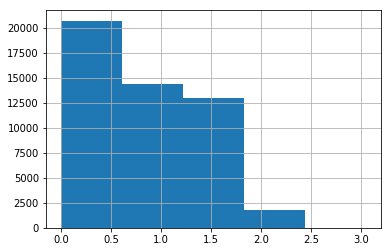

In [34]:
df.cuisine_c.hist(bins = 5);

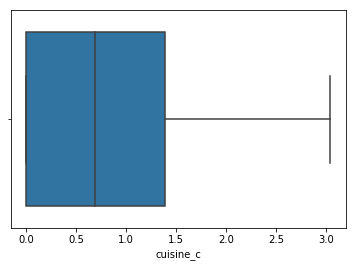

In [35]:
sns.boxplot(df.cuisine_c);

выбросов больше нет, экспоненциальное распределение осталось

# *колонка* **rating**

уникальные значения [0.  3.5 4.  4.5 5.  3.  2.5 2.  1.  1.5]
значения и их количество
 4.0    13692
4.5    10929
0.0    10000
3.5     6824
5.0     3879
3.0     2955
2.5      915
2.0      466
1.0      201
1.5      139
Name: rating, dtype: int64


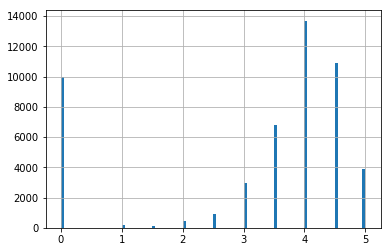

In [36]:
print('уникальные значения', df.rating.unique())
print('значения и их количество\n', df.rating.value_counts())
df.rating.hist(bins = 100);

значения целевой переменной имеет шаг 0,5, распределено примерно нормально

# *колонка* **price**

In [37]:
print('уникальные значения', df.price.unique())
price_vl = df.price.value_counts()
print('значения и их количество\n', price_vl)
print(df.price.isna().sum()/50000*100)
print(df[df['sample'] == 0].price.isna().sum())
print(df[df['sample'] == 1].price.isna().sum())

уникальные значения ['$$ - $$$' '$$$$' '$' nan]
значения и их количество
 $$ - $$$    23041
$            7816
$$$$         1782
Name: price, dtype: int64
34.721999999999994
3475
13886


In [38]:
# проверим колонку на наличие статистически значимых различий
df_stat = pd.DataFrame()
df_stat['price'] = df['price']
df_stat['rating'] = df['rating']
df_stat['sample'] = df['sample']
df_stat = df_stat[df['sample'] == 1]
get_stat_dif('price')

Найдены статистически значимые различия для колонки price


в колонке очень много пропусков, почти 35%, нужно бы ее удалять, но она имеет статистически значимые различия, попробуем это использовать, заменив пропуски пропорционально имеющимся значениям

In [39]:
# пометим строки, где есть NaN
df['price_ind'] = df.price.isna()
df['price_ind'] = df['price_ind'].apply(lambda x: 0 if x else 1)

In [40]:
# заменим пропуски пропорционально имеющимся данным
price_list = [price_vl.index[x] for x in range(3)]
p = [price_vl[z]/price_vl.sum() for z in range(3)]
print(price_list, p)
a = np.random.choice(price_list, df.price.isna().sum(), p=p)
count = 0
for i in range(len(df.price)):
    if pd.isna(df.loc[i, 'price']) :
        df.loc[i, 'price'] = a[count]
        count += 1
print(df.price.value_counts())

['$$ - $$$', '$', '$$$$'] [0.7059346180949171, 0.23946812095958822, 0.054597260945494656]
$$ - $$$    35310
$           11961
$$$$         2729
Name: price, dtype: int64


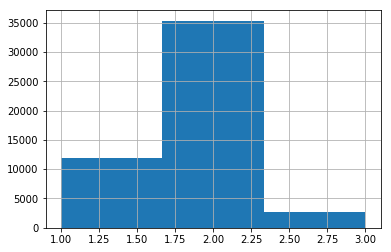

In [41]:
# сохраним колонку с категориальными значениями для последующего преобразования в dummy-переменные
df['price1'] = df.price.copy()
# заменим на числовыми значениями по принципу LabelEncoding
df.price = df.price.apply(lambda x: 1 if x == '$' else 2 if x == '$$ - $$$' else 3)
df.price.hist(bins = 3)

In [42]:
# проверим колонку на наличие статистически значимых различий после манипуляций
df_stat = pd.DataFrame()
df_stat['price'] = df['price']
df_stat['rating'] = df['rating']
df_stat['sample'] = df['sample']
df_stat = df_stat[df['sample'] == 1]
get_stat_dif('price')

Найдены статистически значимые различия для колонки price


# *колонка* **number**

значения и их количество
 2.0       2403
3.0       2042
4.0       1707
5.0       1471
6.0       1258
          ... 
5216.0       1
1932.0       1
1050.0       1
1145.0       1
1471.0       1
Name: number, Length: 1573, dtype: int64
количество пустых строк 3200


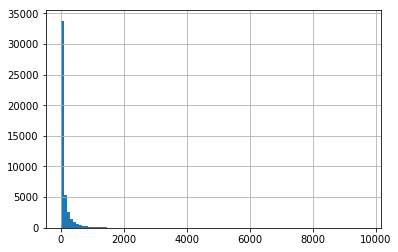

In [43]:
print('значения и их количество\n', df.number.value_counts())
print('количество пустых строк', df.number.isna().sum())
# пометим строки, где есть NaN
df['number_ind'] = df.number.isna()
df['number_ind'] = df['number_ind'].apply(lambda x: 0 if x else 1)
df.number.hist(bins = 100)

In [44]:
df_n = df.copy()
df_n.number.fillna(0, inplace = True)
outliers_iqr(df_n.number)

(-140.0, 252.0)

In [45]:
df_n[df_n.number > 252]

,id,city,cuisine,ranking,price,number,reviews,URL_TA,ID_TA,sample,rating,cuisine_c,price_ind,price1,number_ind
10,id_10,Rome,NaN,1209.0,2,306.0,"[['Very pretentious, but drinks are top notch'...",/Restaurant_Review-g187791-d7818546-Reviews-Je...,d7818546,0,0.0,0.000000,0,$$ - $$$,1
14,id_14,Prague,"['European', 'Czech', 'Eastern European', 'Cen...",1105.0,2,273.0,"[['Good food, beer, value and service', 'Eat u...",/Restaurant_Review-g274707-d1093021-Reviews-U_...,d1093021,0,0.0,1.386294,1,$$ - $$$,1
16,id_16,Milan,"['Pizza', 'Vegetarian Friendly', 'Vegan Options']",1825.0,2,322.0,"[['truly Neapolitan pizza, new/slick location'...",/Restaurant_Review-g187849-d11850449-Reviews-P...,d11850449,0,0.0,1.098612,1,$$ - $$$,1
17,id_17,London,"['Bar', 'British', 'Pub', 'Vegetarian Friendly...",2349.0,2,282.0,"[['Quite a decent pub', 'in the middle of noth...",/Restaurant_Review-g186338-d2188276-Reviews-Th...,d2188276,0,0.0,1.609438,1,$$ - $$$,1
29,id_29,Oslo,"['French', 'European', 'Norwegian', 'Italian',...",550.0,2,465.0,"[['Lovely food!', 'Nightmare'], ['02/26/2017',...",/Restaurant_Review-g190479-d1495732-Reviews-Mo...,d1495732,0,0.0,1.791759,1,$$ - $$$,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49980,id_253,Rome,"['Italian', 'Seafood', 'Mediterranean', 'Europ...",254.0,2,560.0,[['Creative cocktails and pleasant atmosphere....,/Restaurant_Review-g187791-d8273642-Reviews-Su...,d8273642,1,4.5,1.791759,1,$$ - $$$,1
49985,id_56,Brussels,"['African', 'Ethiopian', 'Vegetarian Friendly'...",57.0,2,989.0,"[['A nice experience with Ethiopian food', 'A ...",/Restaurant_Review-g188644-d778285-Reviews-Kok...,d778285,1,4.0,1.386294,1,$$ - $$$,1
49992,id_13,Stockholm,"['Swedish', 'Scandinavian', 'Vegetarian Friend...",14.0,2,1162.0,"[['Great Viking Dinner', 'A foot stompingly go...",/Restaurant_Review-g189852-d2560559-Reviews-Ai...,d2560559,1,4.5,1.386294,1,$$ - $$$,1
49996,id_6340,Paris,"['French', 'American', 'Bar', 'European', 'Veg...",6341.0,2,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,3.5,1.609438,1,$$ - $$$,1


очень проблематичная колонка, количество пустых срок превышает количество самого распространенного значения, а количество выбросов почти 6000, если принять, что отсутствие отзывов приравнивается к нулю

In [46]:
df_isna = df[df.number.isna()]
df_isna['reviews'].unique()

array(['[[], []]', '[["Nova\' Doba"], [\'01/26/2017\']]',
       "[['South American food at its best!'], ['09/05/2013']]", ...,
       "[['Small, Friendly Place on the Mile'], ['11/15/2015']]",
       "[['Personal expirence'], ['10/27/2017']]",
       "[['I love this place!'], ['08/24/2015']]"], dtype=object)

In [47]:
df_isna['reviews'].nunique()

1177

In [48]:
df_isna.reviews.isna().sum()

1

In [49]:
df_isna[df_isna.reviews.isna()]

,id,city,cuisine,ranking,price,number,reviews,URL_TA,ID_TA,sample,rating,cuisine_c,price_ind,price1,number_ind
9608,id_9608,Vienna,NaN,1779.0,2,NaN,NaN,/Restaurant_Review-g190454-d12605368-Reviews-R...,d12605368,0,0.0,0.0,0,$$ - $$$,0


In [50]:
df_isna['reviews'].value_counts()

[[], []]                                                               2023
[['A warm welcome and a great breakfast'], ['05/14/2017']]                1
[['Best Pizza of our Trip'], ['04/22/2014']]                              1
[['Surprisingly good'], ['06/09/2017']]                                   1
[['Cozy and laid back'], ['07/17/2013']]                                  1
                                                                       ... 
[['God Tier'], ['12/03/2017']]                                            1
[['Quick bite'], ['04/28/2016']]                                          1
[['Good ambiance and friendly service'], ['05/31/2016']]                  1
[['Restaurant recommended by concierge'], ['02/28/2016']]                 1
[['Beautiful vegan cafe and country shop in a...'], ['12/28/2017']]       1
Name: reviews, Length: 1177, dtype: int64

при ближайшем рассмотрении мы видим, что пропуски в количестве отзывов верны лишь на 2/3, а в третьи случаев отзывы все-таки имеются
заполним пропуски единицами, если отзывы есть и нулями, если они пустые или отсутствуют

In [51]:
for i in range(len(df)):
    if pd.isna(df.loc[i, 'number']):
        if not pd.isna(df.loc[i, 'reviews']):
            if df.loc[i, 'reviews'][2] != ']':
                df.loc[i, 'number'] = 1

In [52]:
df.number.fillna(0, inplace = True)

In [53]:
outliers_iqr(df.number)

(-140.0, 252.0)

In [54]:
df[df.number > 252.0]

,id,city,cuisine,ranking,price,number,reviews,URL_TA,ID_TA,sample,rating,cuisine_c,price_ind,price1,number_ind
10,id_10,Rome,NaN,1209.0,2,306.0,"[['Very pretentious, but drinks are top notch'...",/Restaurant_Review-g187791-d7818546-Reviews-Je...,d7818546,0,0.0,0.000000,0,$$ - $$$,1
14,id_14,Prague,"['European', 'Czech', 'Eastern European', 'Cen...",1105.0,2,273.0,"[['Good food, beer, value and service', 'Eat u...",/Restaurant_Review-g274707-d1093021-Reviews-U_...,d1093021,0,0.0,1.386294,1,$$ - $$$,1
16,id_16,Milan,"['Pizza', 'Vegetarian Friendly', 'Vegan Options']",1825.0,2,322.0,"[['truly Neapolitan pizza, new/slick location'...",/Restaurant_Review-g187849-d11850449-Reviews-P...,d11850449,0,0.0,1.098612,1,$$ - $$$,1
17,id_17,London,"['Bar', 'British', 'Pub', 'Vegetarian Friendly...",2349.0,2,282.0,"[['Quite a decent pub', 'in the middle of noth...",/Restaurant_Review-g186338-d2188276-Reviews-Th...,d2188276,0,0.0,1.609438,1,$$ - $$$,1
29,id_29,Oslo,"['French', 'European', 'Norwegian', 'Italian',...",550.0,2,465.0,"[['Lovely food!', 'Nightmare'], ['02/26/2017',...",/Restaurant_Review-g190479-d1495732-Reviews-Mo...,d1495732,0,0.0,1.791759,1,$$ - $$$,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49980,id_253,Rome,"['Italian', 'Seafood', 'Mediterranean', 'Europ...",254.0,2,560.0,[['Creative cocktails and pleasant atmosphere....,/Restaurant_Review-g187791-d8273642-Reviews-Su...,d8273642,1,4.5,1.791759,1,$$ - $$$,1
49985,id_56,Brussels,"['African', 'Ethiopian', 'Vegetarian Friendly'...",57.0,2,989.0,"[['A nice experience with Ethiopian food', 'A ...",/Restaurant_Review-g188644-d778285-Reviews-Kok...,d778285,1,4.0,1.386294,1,$$ - $$$,1
49992,id_13,Stockholm,"['Swedish', 'Scandinavian', 'Vegetarian Friend...",14.0,2,1162.0,"[['Great Viking Dinner', 'A foot stompingly go...",/Restaurant_Review-g189852-d2560559-Reviews-Ai...,d2560559,1,4.5,1.386294,1,$$ - $$$,1
49996,id_6340,Paris,"['French', 'American', 'Bar', 'European', 'Veg...",6341.0,2,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,3.5,1.609438,1,$$ - $$$,1


количество выбросов не уменьшилось, но это реальные данные, и мы ничего не сможем с ними сделать

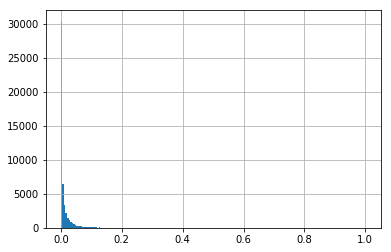

In [55]:
# нормализуем колонку
df.number = MMS(df.number)
df.number.hist(bins = 200)

# *колонка* **reviews**

количество пустых строк 13798


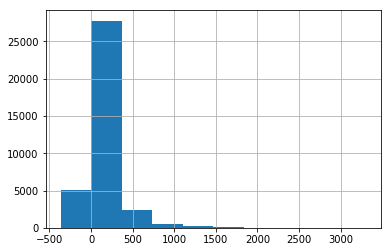

In [56]:
# выделим из колонки даты и посчитаем разницу между ними
df4 = pd.DataFrame(df.reviews)
pattern = re.compile('\d+\/\d+\/\d+')
df4.reviews = df4.reviews.apply(lambda x: re.findall(pattern, str(x)))
df4['date2'] = df4.reviews.apply(lambda x: datetime.strptime(x[-1], '%m/%d/%Y') if len(x) == 2 else np.nan)
df4['date1'] = df4.reviews.apply(lambda x: datetime.strptime(x[0], '%m/%d/%Y') if len(x) == 2 or len(x) == 1 else np.nan)
df4['dt'] = df4.date1 - df4.date2
df4['dt'] = df4['dt'].apply(lambda x: x.days)
print('количество пустых строк', df4.dt.isna().sum())
# пометим пустые строки
df4['dt_ind'] = df4.dt.isna()
df4['dt_ind'] = df4['dt_ind'].apply(lambda x: 0 if x else 1)
df4.dt.hist()

количество пустых строк велико, имеются отрицательные значения временного периода

In [57]:
# отрицательные значения сделаем положительными
df4.dt = np.abs(df4.dt)
dt_vl = df4.dt.value_counts()
print('значения и их количество\n', dt_vl)

значения и их количество
 1.0       829
0.0       631
2.0       629
3.0       606
4.0       538
         ... 
1124.0      1
918.0       1
2425.0      1
1355.0      1
1727.0      1
Name: dt, Length: 1310, dtype: int64


In [58]:
# заменим пропуски пропорционально имеющимся данным
dt_list = [dt_vl.index[x] for x in range(len(dt_vl))]
p = [dt_vl[z]/dt_vl.sum() for z in dt_vl.index]
a = np.random.choice(dt_list, df4.dt.isna().sum(), p=p)
count = 0
for i in range(len(df4.dt)):
    if pd.isna(df4.loc[i, 'dt']) :
        df4.loc[i, 'dt'] = a[count]
        count += 1
print(df4.dt.value_counts())

1.0       1133
2.0        886
0.0        875
3.0        858
4.0        731
          ... 
1403.0       1
1433.0       1
1289.0       1
805.0        1
1114.0       1
Name: dt, Length: 1310, dtype: int64


In [59]:
df['dt'] = df4.dt
df['dt_ind'] = df4['dt_ind']
# нормализуем данные
df.dt = MMS(df.dt)

проведем анализ настроений отзывов

In [60]:
text = df.reviews.str.replace(',', '')
pattern1 = re.compile('\D+')
text = text.apply(lambda x: re.findall(pattern1, str(x)))
analysisPol = text.apply(lambda x: TextBlob(str(x)).polarity)
df['analysisPol'] = analysisPol
analysisSub = text.apply(lambda x: TextBlob(str(x)).subjectivity)
df['analysisSub'] = analysisSub

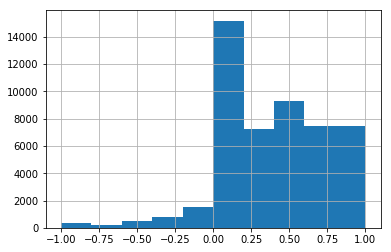

In [61]:
df['analysisPol'].hist()

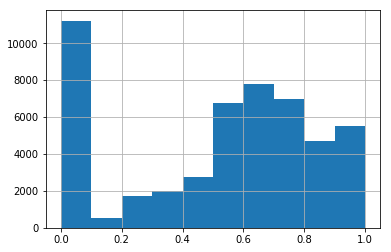

In [62]:
df['analysisSub'].hist()

большинство отзывов положительные, хотя нейтральных больше всего, субъективизм не мал, но самое большое значение малосубъективных отзывов

In [63]:
# выведем матрицу корреляций
corr_matrix = df.drop(columns=['id', 'sample']).corr(method='pearson')
corr_matrix

,ranking,price,number,rating,cuisine_c,price_ind,number_ind,dt,dt_ind,analysisPol,analysisSub
ranking,1.000000,-0.062927,-0.223156,-0.109897,-0.320777,-0.233946,-0.094831,0.105206,-0.149709,-0.204977,-0.118341
price,-0.062927,1.000000,0.134909,-0.006536,0.093370,-0.000621,0.003392,-0.033019,0.034095,0.011971,0.027008
number,-0.223156,0.134909,1.000000,0.011011,0.382942,0.266849,0.106146,-0.143983,0.227142,0.137815,0.143848
rating,-0.109897,-0.006536,0.011011,1.000000,0.034211,0.020519,0.000631,-0.024086,0.005490,0.081667,0.017122
cuisine_c,-0.320777,0.093370,0.382942,0.034211,1.000000,0.642196,0.196323,-0.223459,0.431717,0.240331,0.272759
price_ind,-0.233946,-0.000621,0.266849,0.020519,0.642196,1.000000,0.267568,-0.145313,0.511168,0.243355,0.329264
number_ind,-0.094831,0.003392,0.106146,0.000631,0.196323,0.267568,1.000000,-0.011120,0.423555,0.169902,0.260916
dt,0.105206,-0.033019,-0.143983,-0.024086,-0.223459,-0.145313,-0.011120,1.000000,-0.003798,-0.036746,-0.015101
dt_ind,-0.149709,0.034095,0.227142,0.005490,0.431717,0.511168,0.423555,-0.003798,1.000000,0.359071,0.562176
analysisPol,-0.204977,0.011971,0.137815,0.081667,0.240331,0.243355,0.169902,-0.036746,0.359071,1.000000,0.559503


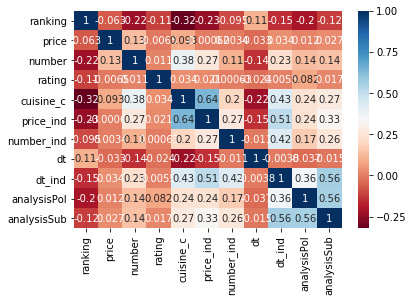

In [64]:
sns.heatmap(corr_matrix, annot = True, cmap="RdBu");

In [65]:
corr_matrix[(corr_matrix > 0.7) | (corr_matrix < -0.7)].fillna('')

,ranking,price,number,rating,cuisine_c,price_ind,number_ind,dt,dt_ind,analysisPol,analysisSub
ranking,1,,,,,,,,,,
price,,1,,,,,,,,,
number,,,1,,,,,,,,
rating,,,,1,,,,,,,
cuisine_c,,,,,1,,,,,,
price_ind,,,,,,1,,,,,
number_ind,,,,,,,1,,,,
dt,,,,,,,,1,,,
dt_ind,,,,,,,,,1,,
analysisPol,,,,,,,,,,1,


сильно скоррелированных данных нет, можно приступать к обучению модели

In [66]:
# создадим dummy-переменные из колонок с городами и ценовой категории
df = pd.get_dummies(df, columns=['city'], prefix='city')
df = pd.get_dummies(df, columns=['price1'], prefix='price')

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [67]:
train_data = df[df['sample'] == 1].drop(columns=['id', 'cuisine', 'reviews', 'sample', 'URL_TA', 'ID_TA'])
test_data = df[df['sample'] == 0].drop(columns=['id', 'cuisine', 'reviews', 'sample', 'URL_TA', 'ID_TA'])

y = train_data.rating.values            # наш таргет
X = train_data.drop(columns='rating')

In [68]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [69]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 45), (40000, 45), (40000, 44), (32000, 44), (8000, 44))

# Model 
Сам ML

In [70]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [71]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [72]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [73]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.215596875


In [74]:
y_pred_rnd = round_pred(y_pred)
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_rnd))

MAE: 0.18525


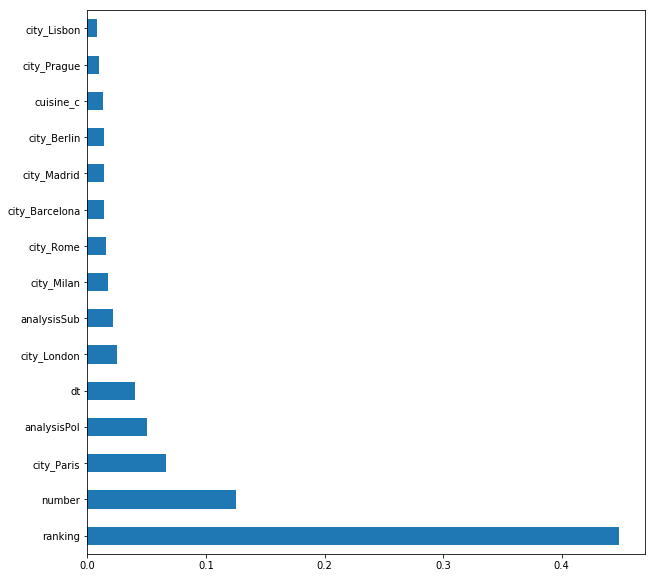

In [75]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [76]:
test_data.sample(20)

,ranking,price,number,rating,cuisine_c,price_ind,number_ind,dt,dt_ind,analysisPol,...,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich,price_$,price_$$ - $$$,price_$$$$
3004,2380.0,2,0.000725,0.0,0.000000,0,1,0.072816,0,0.450000,...,0,0,0,0,0,0,0,0,1,0
6507,5626.0,2,0.000414,0.0,0.693147,1,1,0.000910,1,0.000000,...,0,0,0,0,0,0,0,0,1,0
8759,1812.0,1,0.000311,0.0,0.000000,0,1,0.003337,0,0.000000,...,0,0,0,0,0,0,0,1,0,0
5795,3768.0,3,0.019772,0.0,1.098612,1,1,0.008192,1,0.273929,...,1,0,0,0,0,0,0,0,0,1
6897,782.0,2,0.000104,0.0,0.000000,0,0,0.022148,0,0.000000,...,0,0,0,0,0,0,0,0,1,0
71,7458.0,1,0.001139,0.0,0.000000,1,1,0.024272,1,0.303125,...,0,0,0,0,0,0,0,1,0,0
518,198.0,2,0.014596,0.0,1.791759,1,1,0.000303,1,0.366667,...,0,0,0,0,0,0,0,0,1,0
8810,3016.0,2,0.001656,0.0,0.000000,1,1,0.000000,1,0.550000,...,0,0,0,0,0,0,0,0,1,0
3188,738.0,1,0.017081,0.0,1.386294,1,1,0.027002,1,0.900000,...,0,0,0,0,0,0,0,1,0,0
5140,5203.0,2,0.011698,0.0,0.693147,1,1,0.101335,1,0.866667,...,0,0,0,0,0,0,0,0,1,0


In [77]:
test_data = test_data.drop(columns='rating')

In [78]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [79]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [80]:
predict_submission

array([3.13 , 4.31 , 4.465, ..., 3.455, 4.49 , 4.19 ])

In [81]:
predict_submission = round_pred(predict_submission)
predict_submission[:10]

[3.0, 4.5, 4.5, 4.5, 4.5, 4.5, 2.5, 3.0, 4.0, 4.5]

In [82]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.5
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,2.5
7,id_7,3.0
8,id_8,4.0
9,id_9,4.5
